# Gerador de instâncias sintéticas para o problema de otimização do mestrado

### Etapas

**Geral**

1. Definir o grid

1. Definir bacias geológicas

1. Definir plays

1. Definir quantidade de projetos

**Para cada projeto:**

1. Escolher uma bacia

1. Sortear coordenada (x,y)

1. Pela bacia, temos a estratégia e a qualidade do dado

1. Dada a bacia, escolher um play

1. O play vai indicar o range de soterramento, e distribuição dos parâmetros volumétricos

1. O risco tem componentes regionais da bacia (geração), componentes do play (migração, retenção), e componentes individuais (geometria e reservatório).

1. A PCGNA é indicada pelo play

1. Simular volume geo, tec, ambos condicionais e incondicionais

1. Cada bacia tem uma $f(vol) \rightarrow VPL$

1. Calcular distribuição de VPL e métricas de retorno (risco?)

1. O custo do poço exploratório depende da bacia, estratégia e soterramento

1. Tempo de excecução dos projetos é função do soterramento e estratégia

1. Atribuir contratos à cada parte da bacia com OEs: simular leilões?

## Importando bibliotecas

In [1]:
import copy
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm

%matplotlib inline

## Definição do grid

In [2]:
x_min, x_max = (0., 100.)
y_min, y_max = (0., 100.)
dx, dy = (1., 1.)
grid = np.zeros(( int((y_max-y_min)/dy), int((x_max-x_min)/dx) ))

In [3]:
grid.shape

(100, 100)

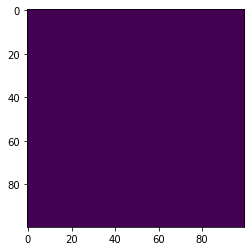

In [4]:
plt.imshow(grid)

## Criando bacias geológicas

In [5]:
estrategias = ['Estrutura pronta', 'Estrutura em construção', 'Nova fronteira']
qualidades_dado = ['Qualidade alta', 'Qualidade razoável', 'Qualidade baixa']

In [6]:
nx_bacias = 3
ny_bacias = 3
bacias = {}
count = 0
x_step = (x_max-x_min)/nx_bacias
y_step = (y_max-y_min)/ny_bacias
for i in range(1, ny_bacias+1):
    y_min_curr = (i-1)*y_step
    y_max_curr = (i)*y_step
    for j in range(1, nx_bacias+1):
        x_min_curr = (j-1)*x_step
        x_max_curr = j*x_step
        count += 1
        bacias["Bacia"+str(count)] = {}
        bacias["Bacia"+str(count)]['Coordenadas'] = ((x_min_curr, x_max_curr),(y_min_curr, y_max_curr))
        bacias["Bacia"+str(count)]['Maturidade'] = np.random.choice(estrategias)
        bacias["Bacia"+str(count)]['Qualidade do dado'] = np.random.choice(qualidades_dado)
        grid[int(x_min_curr):int(x_max_curr), int(y_min_curr):int(y_max_curr)] = count

In [7]:
bacias

{'Bacia1': {'Coordenadas': ((0.0, 33.333333333333336),
   (0.0, 33.333333333333336)),
  'Maturidade': 'Estrutura pronta',
  'Qualidade do dado': 'Qualidade alta'},
 'Bacia2': {'Coordenadas': ((33.333333333333336, 66.66666666666667),
   (0.0, 33.333333333333336)),
  'Maturidade': 'Estrutura pronta',
  'Qualidade do dado': 'Qualidade alta'},
 'Bacia3': {'Coordenadas': ((66.66666666666667, 100.0),
   (0.0, 33.333333333333336)),
  'Maturidade': 'Estrutura em construção',
  'Qualidade do dado': 'Qualidade razoável'},
 'Bacia4': {'Coordenadas': ((0.0, 33.333333333333336),
   (33.333333333333336, 66.66666666666667)),
  'Maturidade': 'Estrutura em construção',
  'Qualidade do dado': 'Qualidade baixa'},
 'Bacia5': {'Coordenadas': ((33.333333333333336, 66.66666666666667),
   (33.333333333333336, 66.66666666666667)),
  'Maturidade': 'Estrutura pronta',
  'Qualidade do dado': 'Qualidade alta'},
 'Bacia6': {'Coordenadas': ((66.66666666666667, 100.0),
   (33.333333333333336, 66.66666666666667)),
  '

In [8]:
colormap_dict = cm.cmap_d.keys()
colormap_dict

dict_keys(['magma', 'inferno', 'plasma', 'viridis', 'cividis', 'twilight', 'twilight_shifted', 'Blues', 'BrBG', 'BuGn', 'BuPu', 'CMRmap', 'GnBu', 'Greens', 'Greys', 'OrRd', 'Oranges', 'PRGn', 'PiYG', 'PuBu', 'PuBuGn', 'PuOr', 'PuRd', 'Purples', 'RdBu', 'RdGy', 'RdPu', 'RdYlBu', 'RdYlGn', 'Reds', 'Spectral', 'Wistia', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd', 'afmhot', 'autumn', 'binary', 'bone', 'brg', 'bwr', 'cool', 'coolwarm', 'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_gray', 'gist_heat', 'gist_ncar', 'gist_rainbow', 'gist_stern', 'gist_yarg', 'gnuplot', 'gnuplot2', 'gray', 'hot', 'hsv', 'jet', 'nipy_spectral', 'ocean', 'pink', 'prism', 'rainbow', 'seismic', 'spring', 'summer', 'terrain', 'winter', 'Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c', 'magma_r', 'inferno_r', 'plasma_r', 'viridis_r', 'cividis_r', 'twilight_r', 'twilight_shifted_r', 'Blues_r', 'BrBG_r', 'BuGn_r', 'BuPu_r', 'CMRmap_r', 'GnBu_r', 'Greens_r', 

In [9]:
colormap = cm.inferno

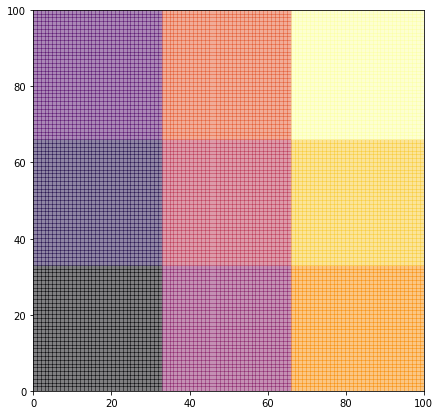

In [10]:
plt.figure(figsize=(7, 7))
plt.pcolormesh(grid, alpha=0.5, cmap=colormap)

## Criando projetos

In [11]:
n_plays = 10
plays = ['Play '+str(i) for i in range(1, n_plays+1)]

In [12]:
n_projetos = 20
projetos = {}
projetos['Coordenada x'] = []
projetos['Coordenada y'] = []
projetos['Bacia'] = []
projetos['Nome'] = []
projetos['Maturidade bacia'] = []
projetos['Qualidade do dado'] = []
projetos['Play'] = []

for i in range(n_projetos):
    
    # primeiro, sortear uma bacia
    bacia = np.random.choice(list(bacias.keys()))
    
    # não permitir coordenadas nas bordas das bacias
    fator = 0.8
    x_min_curr, x_max_curr = bacias[bacia]['Coordenadas'][0]
    y_min_curr, y_max_curr = bacias[bacia]['Coordenadas'][1]
    
    x_proj, y_proj = (np.random.uniform(x_min_curr + x_step*(1-fator), x_max_curr - x_step*(1-fator)), 
                      np.random.uniform(y_min_curr + y_step*(1-fator), y_max_curr - y_step*(1-fator)))
    
    projetos['Nome'].append("Projeto " + str(i+1))
    projetos['Bacia'].append(bacia)
    projetos['Coordenada x'].append(x_proj)
    projetos['Coordenada y'].append(y_proj)
    projetos['Maturidade bacia'].append(bacias[bacia]['Maturidade'])
    projetos['Qualidade do dado'].append(bacias[bacia]['Qualidade do dado'])
    projetos['Play'].append(np.random.choice(plays))

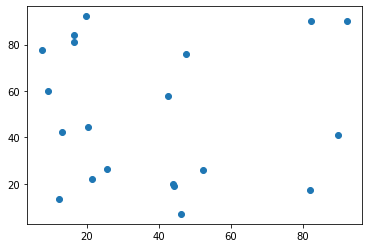

In [13]:
plt.scatter(projetos['Coordenada x'], projetos['Coordenada y'])

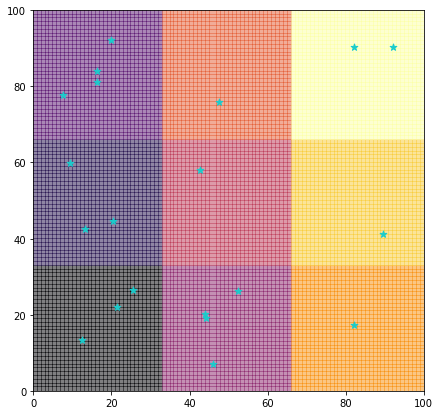

In [14]:
fig = plt.figure(figsize=(7, 7), frameon=False)

im1 = plt.pcolormesh(grid, alpha=0.5, cmap=colormap)
im2 = plt.scatter(projetos['Coordenada x'], projetos['Coordenada y'], color=(0.1, 0.8, 0.8), s=50, marker='*')

plt.show()

In [15]:
proj_df = pd.DataFrame(projetos)

In [16]:
proj_df

,Coordenada x,Coordenada y,Bacia,Nome,Maturidade bacia,Qualidade do dado,Play
0,44.143174,19.176742,Bacia2,Projeto 1,Estrutura pronta,Qualidade alta,Play 4
1,46.111843,7.037111,Bacia2,Projeto 2,Estrutura pronta,Qualidade alta,Play 2
2,43.959508,20.146113,Bacia2,Projeto 3,Estrutura pronta,Qualidade alta,Play 7
3,92.078156,90.396075,Bacia9,Projeto 4,Nova fronteira,Qualidade alta,Play 6
4,20.307964,44.496946,Bacia4,Projeto 5,Estrutura em construção,Qualidade baixa,Play 6
5,7.636699,77.777898,Bacia7,Projeto 6,Estrutura em construção,Qualidade alta,Play 6
6,19.864001,92.249476,Bacia7,Projeto 7,Estrutura em construção,Qualidade alta,Play 6
7,82.125210,90.233700,Bacia9,Projeto 8,Nova fronteira,Qualidade alta,Play 1
8,52.394887,26.116602,Bacia2,Projeto 9,Estrutura pronta,Qualidade alta,Play 5
9,47.431240,75.924865,Bacia8,Projeto 10,Estrutura pronta,Qualidade alta,Play 5


In [17]:
proj_df['Bacia'].unique(), proj_df['Maturidade bacia'].unique(), proj_df['Qualidade do dado'].unique(), proj_df['Play'].unique()

(array(['Bacia2', 'Bacia9', 'Bacia4', 'Bacia7', 'Bacia8', 'Bacia1',
        'Bacia6', 'Bacia5', 'Bacia3'], dtype=object),
 array(['Estrutura pronta', 'Nova fronteira', 'Estrutura em construção'],
       dtype=object),
 array(['Qualidade alta', 'Qualidade baixa', 'Qualidade razoável'],
       dtype=object),
 array(['Play 4', 'Play 2', 'Play 7', 'Play 6', 'Play 1', 'Play 5',
        'Play 8', 'Play 3', 'Play 9'], dtype=object))

## Definindo parâmetros volumétricos e risco geológico

In [18]:
soterramento_range = (1000., 5000.)

pcgna_range = (0., 1.)

area_range = (20., 200.)
netpay_range = (5., 100.)
phi_range = (0.10, 0.32)
trapfill_range = (0.5, 1.)
shc_range = (0.5, 1.)
bo_range = (1.4, 1.9)
bg_range = (0.002, 0.004)
rgo_range = (150, 250)
rlg_range = (0.1, 0.15)
froleo_range = (0.15, 0.25)
frga_range = (0.15, 0.25)
frgna_range = (0.15, 0.25)
frcond_range = (0.15, 0.25)

### TODO: colocar correlação nas variáveis aleatórias

In [19]:
plays_completo = {}
for p in plays:
    plays_completo[copy.copy(p)] = {}
    
    loc, scale = soterramento_range[0], soterramento_range[1]-soterramento_range[0]
    plays_completo[copy.copy(p)]['Soterramento'] = stats.uniform(loc, scale).rvs(2)
    
    loc, scale = pcgna_range[0], pcgna_range[1] - pcgna_range[0]
    plays_completo[copy.copy(p)]['pcgna'] = stats.uniform(loc, scale).rvs(2)
    
    loc, scale = area_range[0], area_range[1] - area_range[0]
    plays_completo[copy.copy(p)]['area'] = stats.uniform(loc, scale).rvs(2)
    
    loc, scale = netpay_range[0], netpay_range[1] - netpay_range[0]
    plays_completo[copy.copy(p)]['netpay'] = stats.uniform(loc, scale).rvs(2)
    
    loc, scale = phi_range[0], phi_range[1] - phi_range[0]
    plays_completo[copy.copy(p)]['phi'] = stats.uniform(loc, scale).rvs(2)
    
    loc, scale = trapfill_range[0], trapfill_range[1] - trapfill_range[0]
    plays_completo[copy.copy(p)]['trapfill'] = stats.uniform(loc, scale).rvs(2)
    
    loc, scale = shc_range[0], shc_range[1] - shc_range[0]
    plays_completo[copy.copy(p)]['shc'] = stats.uniform(loc, scale).rvs(2)
    
    loc, scale = bo_range[0], bo_range[1] - bo_range[0]
    plays_completo[copy.copy(p)]['bo'] = stats.uniform(loc, scale).rvs(2)
    
    loc, scale = bg_range[0], bg_range[1] - bg_range[0]
    plays_completo[copy.copy(p)]['bg'] = stats.uniform(loc, scale).rvs(2)
    
    loc, scale = rgo_range[0], rgo_range[1] - rgo_range[0]
    plays_completo[copy.copy(p)]['rgo'] = stats.uniform(loc, scale).rvs(2)
    
    loc, scale = rlg_range[0], rlg_range[1] - rlg_range[0]
    plays_completo[copy.copy(p)]['rlg'] = stats.uniform(loc, scale).rvs(2)
    
    loc, scale = froleo_range[0], froleo_range[1] - froleo_range[0]
    plays_completo[copy.copy(p)]['froleo'] = stats.uniform(loc, scale).rvs(2)
    
    loc, scale = frga_range[0], frga_range[1] - frga_range[0]
    plays_completo[copy.copy(p)]['frga'] = stats.uniform(loc, scale).rvs(2)
    
    loc, scale = frgna_range[0], frgna_range[1] - frgna_range[0]
    plays_completo[copy.copy(p)]['frgna'] = stats.uniform(loc, scale).rvs(2)
    
    loc, scale = frcond_range[0], frcond_range[1] - frcond_range[0]
    plays_completo[copy.copy(p)]['frcond'] = stats.uniform(loc, scale).rvs(2)

In [20]:
plays_completo

{'Play 1': {'Soterramento': array([3982.77709461, 3476.55914122]),
  'pcgna': array([0.66348232, 0.82634054]),
  'area': array([111.34284204, 138.89130106]),
  'netpay': array([41.76472574, 86.01694758]),
  'phi': array([0.16125926, 0.15769311]),
  'trapfill': array([0.76187735, 0.6097338 ]),
  'shc': array([0.84459992, 0.99166878]),
  'bo': array([1.47750842, 1.7083014 ]),
  'bg': array([0.0030393 , 0.00305514]),
  'rgo': array([171.85038558, 195.50121443]),
  'rlg': array([0.12313179, 0.10919879]),
  'froleo': array([0.16170963, 0.22310962]),
  'frga': array([0.16227395, 0.24239227]),
  'frgna': array([0.15019869, 0.16342368]),
  'frcond': array([0.23553461, 0.24292071])},
 'Play 2': {'Soterramento': array([2040.18880612, 4125.85213955]),
  'pcgna': array([0.7272459 , 0.86768829]),
  'area': array([ 21.00442796, 101.25983812]),
  'netpay': array([ 7.61132224, 20.1818707 ]),
  'phi': array([0.17400924, 0.20125017]),
  'trapfill': array([0.93342648, 0.69719144]),
  'shc': array([0.6094

### TODO: escalar incerteza pela qualidade do dado e maturidade da bacia

### TODO: colocar fatores de risco com compentes por bacia, play, e prospecto

In [21]:
def ComputeDist(p90_play, p10_play):
    loc, scale = p90_play, p10_play - p90_play
    p90_proj, p10_proj = sorted(stats.uniform(loc, scale).rvs(2))
    mu = (np.log(p90_proj) + np.log(p10_proj)) / 2
    sigma = (np.log(p10_proj)-mu) / 1.2815515655446
    dist = stats.lognorm(s=sigma, scale=np.exp(mu))
    return dist

projetos['Soterramento'] = []
projetos['pcgna'] = []
projetos['area'] = []
projetos['netpay'] = []
projetos['phi'] = []
projetos['trapfill'] = []
projetos['shc'] = []
projetos['bo'] = []
projetos['bg'] = []
projetos['rgo'] = []
projetos['rlg'] = []
projetos['froleo'] = []
projetos['frga'] = []
projetos['frgna'] = []
projetos['frcond'] = []
projetos['geração'] = []
projetos['migração'] = []
projetos['reservatório'] = []
projetos['geometria'] = []
projetos['retenção'] = []
projetos['PS HC'] = []

for k, p in enumerate(projetos['Nome']):
    
    play = projetos['Play'][k]
    
    soterr_p90_play, soterr_p10_play = sorted(plays_completo[play]['Soterramento']) # soterramento
    pcgna_p90_play, pcgna_p10_play = sorted(plays_completo[play]['pcgna']) # pcgna 
    area_p90_play, area_p10_play = sorted(plays_completo[play]['area']) # area
    netpay_p90_play, netpay_p10_play = sorted(plays_completo[play]['netpay']) # netpay 
    phi_p90_play, phi_p10_play = sorted(plays_completo[play]['phi']) # phi 
    trapfill_p90_play, trapfill_p10_play = sorted(plays_completo[play]['trapfill']) # trapfill 
    shc_p90_play, shc_p10_play = sorted(plays_completo[play]['shc']) # shc 
    bo_p90_play, bo_p10_play = sorted(plays_completo[play]['bo']) # bo 
    bg_p90_play, bg_p10_play = sorted(plays_completo[play]['bg']) # bg 
    rgo_p90_play, rgo_p10_play = sorted(plays_completo[play]['rgo']) # rgo 
    rlg_p90_play, rlg_p10_play = sorted(plays_completo[play]['rlg']) # rlg 
    froleo_p90_play, froleo_p10_play = sorted(plays_completo[play]['froleo']) # froleo 
    frga_p90_play, frga_p10_play = sorted(plays_completo[play]['frga']) # frga 
    frgna_p90_play, frgna_p10_play = sorted(plays_completo[play]['frgna']) # frgna
    frcond_p90_play, frcond_p10_play = sorted(plays_completo[play]['frcond']) # frcond
    
    loc, scale = soterr_p90_play, soterr_p10_play - soterr_p90_play
    soterramento = stats.uniform(loc, scale).rvs(1)[0]
    projetos['Soterramento'].append(soterramento)
    
    loc, scale = pcgna_p90_play, pcgna_p10_play - pcgna_p90_play
    pcgna = stats.uniform(loc, scale).rvs(1)[0]
    projetos['pcgna'].append(pcgna)
    
    # area
    area_dist = ComputeDist(area_p90_play, area_p10_play)
    projetos['area'].append(area_dist)
    # netpay
    netpay_dist = ComputeDist(netpay_p90_play, netpay_p10_play)
    projetos['netpay'].append(netpay_dist)
    # phi
    phi_dist = ComputeDist(phi_p90_play, phi_p10_play)
    projetos['phi'].append(phi_dist)
    # trapfill
    trapfill_dist = ComputeDist(trapfill_p90_play, trapfill_p10_play)
    projetos['trapfill'].append(trapfill_dist)
    # shc
    shc_dist = ComputeDist(shc_p90_play, shc_p10_play)
    projetos['shc'].append(shc_dist)
    # bo
    bo_dist = ComputeDist(bo_p90_play, bo_p10_play)
    projetos['bo'].append(bo_dist)
    # bg
    bg_dist = ComputeDist(bg_p90_play, bg_p10_play)
    projetos['bg'].append(bg_dist)
    # rgo
    rgo_dist = ComputeDist(rgo_p90_play, rgo_p10_play)
    projetos['rgo'].append(rgo_dist)
    # rlg
    rlg_dist = ComputeDist(rlg_p90_play, rlg_p10_play)
    projetos['rlg'].append(rlg_dist)
    # froleo
    froleo_dist = ComputeDist(froleo_p90_play, froleo_p10_play)
    projetos['froleo'].append(froleo_dist)
    # frga
    frga_dist = ComputeDist(frga_p90_play, frga_p10_play)
    projetos['frga'].append(frga_dist)
    # frgna
    frgna_dist = ComputeDist(frgna_p90_play, frgna_p10_play)
    projetos['frgna'].append(frgna_dist)
    # frcond
    frcond_dist = ComputeDist(frcond_p90_play, frcond_p10_play)
    projetos['frcond'].append(frcond_dist)
    
    geracao = stats.uniform(0.4, 0.6).rvs(1)[0]
    projetos['geração'].append(geracao)
    migracao = stats.uniform(0.4, 0.6).rvs(1)[0]
    projetos['migração'].append(migracao)
    reservatorio = stats.uniform(0.4, 0.6).rvs(1)[0]
    projetos['reservatório'].append(reservatorio)
    geometria = stats.uniform(0.4, 0.6).rvs(1)[0]
    projetos['geometria'].append(geometria)
    retencao = stats.uniform(0.4, 0.6).rvs(1)[0]
    projetos['retenção'].append(retencao)
    projetos['PS HC'].append( geracao*migracao*reservatorio*geometria*retencao )
    

In [22]:
proj_df = pd.DataFrame(projetos)

In [23]:
proj_df.head()

,Coordenada x,Coordenada y,Bacia,Nome,Maturidade bacia,Qualidade do dado,Play,Soterramento,pcgna,area,...,froleo,frga,frgna,frcond,geração,migração,reservatório,geometria,retenção,PS HC
0,44.143174,19.176742,Bacia2,Projeto 1,Estrutura pronta,Qualidade alta,Play 4,1300.219960,0.728105,<scipy.stats._distn_infrastructure.rv_frozen o...,...,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,0.925389,0.500292,0.513267,0.688897,0.448375,0.073399
1,46.111843,7.037111,Bacia2,Projeto 2,Estrutura pronta,Qualidade alta,Play 2,2948.445884,0.854816,<scipy.stats._distn_infrastructure.rv_frozen o...,...,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,0.747161,0.889573,0.671420,0.508939,0.495468,0.112531
2,43.959508,20.146113,Bacia2,Projeto 3,Estrutura pronta,Qualidade alta,Play 7,2787.541120,0.533949,<scipy.stats._distn_infrastructure.rv_frozen o...,...,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,0.689424,0.797442,0.751352,0.478646,0.647110,0.127945
3,92.078156,90.396075,Bacia9,Projeto 4,Nova fronteira,Qualidade alta,Play 6,1411.462092,0.633614,<scipy.stats._distn_infrastructure.rv_frozen o...,...,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,0.766729,0.777642,0.483221,0.824925,0.885563,0.210475
4,20.307964,44.496946,Bacia4,Projeto 5,Estrutura em construção,Qualidade baixa,Play 6,1626.361896,0.618446,<scipy.stats._distn_infrastructure.rv_frozen o...,...,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,<scipy.stats._distn_infrastructure.rv_frozen o...,0.644283,0.757558,0.642335,0.818562,0.856880,0.219900


In [24]:
proj_df[['geração', 'migração', 'reservatório', 'geometria', 'retenção', 'PS HC']].describe()

,geração,migração,reservatório,geometria,retenção,PS HC
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.723008,0.738927,0.585316,0.682638,0.694730,0.149980
std,0.186405,0.162931,0.137120,0.168304,0.177430,0.082113
min,0.405350,0.422367,0.419544,0.407381,0.402209,0.041622
25%,0.617292,0.605847,0.472860,0.527603,0.532500,0.088830
50%,0.719293,0.787542,0.579280,0.687937,0.688988,0.120238
75%,0.870456,0.840941,0.683499,0.830772,0.862247,0.221099
max,0.989857,0.995457,0.894046,0.949395,0.968835,0.296160


In [25]:
list(projetos.keys())

['Coordenada x',
 'Coordenada y',
 'Bacia',
 'Nome',
 'Maturidade bacia',
 'Qualidade do dado',
 'Play',
 'Soterramento',
 'pcgna',
 'area',
 'netpay',
 'phi',
 'trapfill',
 'shc',
 'bo',
 'bg',
 'rgo',
 'rlg',
 'froleo',
 'frga',
 'frgna',
 'frcond',
 'geração',
 'migração',
 'reservatório',
 'geometria',
 'retenção',
 'PS HC']

## Simulação dos volumes condicionais e incondicionais (Monte Carlo)

In [26]:
iteracoes = 1000

projetos['volume oleo'] = []
projetos['volume ga'] = []
projetos['volume gna'] = []
projetos['volume cond'] = []
projetos['volume condicional'] = []
projetos['média condicional'] = []
projetos['volume incondicional'] = []
projetos['média incondicional'] = []

for k in range(n_projetos):
    
    volume_oleo_dist = []
    volume_ga_dist = []
    volume_gna_dist = []
    volume_cond_dist = []
    volume_hc_dist = []
    volume_condicional_dist = []
    volume_incondicional_dist = []
    
    for i in range(iteracoes):
        
        # sortear se é uma descoberta
        descoberta = stats.uniform(0, 1).rvs(1)[0] < projetos['PS HC'][k]
        
        # sortear o flúido principal
        fluido = 'óleo' if stats.uniform(0, 1).rvs(1)[0] < projetos['pcgna'][k] else 'gás'
        
        # dado o flúido principal, calcular volumes
        area = projetos['area'][k].rvs(1)[0]
        netpay = projetos['netpay'][k].rvs(1)[0]
        phi = projetos['phi'][k].rvs(1)[0]
        trapfill = projetos['trapfill'][k].rvs(1)[0]
        shc = projetos['shc'][k].rvs(1)[0]
        bo = projetos['bo'][k].rvs(1)[0]
        bg = projetos['bg'][k].rvs(1)[0]
        rgo = projetos['rgo'][k].rvs(1)[0]
        rlg = projetos['rlg'][k].rvs(1)[0]
        froleo = projetos['froleo'][k].rvs(1)[0]
        frga = projetos['frga'][k].rvs(1)[0]
        frgna = projetos['frgna'][k].rvs(1)[0]
        frcond = projetos['frcond'][k].rvs(1)[0]
        
        if fluido == 'óleo':
            comum = area * netpay * phi * trapfill * shc
            volume_oleo = ((comum * froleo) / bo) / (0.159)
            volume_ga = ((comum * rgo * frga) / bo)/(1000*0.159)
            volume_hc = volume_oleo + volume_ga
            volume_oleo_dist.append(volume_oleo)
            volume_ga_dist.append(volume_ga)
        elif fluido == 'gás':
            comum = area * netpay * phi * trapfill * shc
            volume_gna = ((comum * frgna) / bg) / (1000*0.159)
            volume_cond = ((comum * rlg * frcond) / bg) / (1000*0.159)
            volume_hc = volume_gna + volume_cond
            volume_gna_dist.append(volume_gna)
            volume_cond_dist.append(volume_cond)
        
        volume_hc_incond = volume_hc if descoberta else 0
        volume_condicional_dist.append(volume_hc)
        volume_incondicional_dist.append(volume_hc_incond)
        
    projetos['volume oleo'].append(volume_oleo_dist)
    projetos['volume ga'].append(volume_ga_dist)
    projetos['volume gna'].append(volume_gna_dist)
    projetos['volume cond'].append(volume_cond_dist)
    projetos['volume condicional'].append(volume_condicional_dist)
    projetos['média condicional'].append(np.mean(volume_condicional_dist))
    projetos['volume incondicional'].append(volume_incondicional_dist)
    projetos['média incondicional'].append(np.mean(volume_incondicional_dist))

In [27]:
proj_df = pd.DataFrame(projetos)

In [28]:
proj_df.head()

,Coordenada x,Coordenada y,Bacia,Nome,Maturidade bacia,Qualidade do dado,Play,Soterramento,pcgna,area,...,retenção,PS HC,volume oleo,volume ga,volume gna,volume cond,volume condicional,média condicional,volume incondicional,média incondicional
0,44.143174,19.176742,Bacia2,Projeto 1,Estrutura pronta,Qualidade alta,Play 4,1300.219960,0.728105,<scipy.stats._distn_infrastructure.rv_frozen o...,...,0.448375,0.073399,"[106.3384885138626, 202.72825637302674, 81.469...","[20.639931913855616, 35.811309512400484, 16.31...","[34.62143899369812, 59.692860244258874, 45.884...","[5.710116857178474, 9.300082299692708, 7.99685...","[126.97842042771822, 238.53956588542724, 97.78...",125.377606,"[0, 238.53956588542724, 0, 0, 0, 0, 0, 0, 0, 0...",9.326996
1,46.111843,7.037111,Bacia2,Projeto 2,Estrutura pronta,Qualidade alta,Play 2,2948.445884,0.854816,<scipy.stats._distn_infrastructure.rv_frozen o...,...,0.495468,0.112531,"[21.324036585240844, 31.076183177357287, 35.86...","[5.700143019566731, 7.980377115557507, 10.1474...","[27.123832611291768, 20.984937196377512, 18.39...","[2.8410488544477706, 2.3137448665753344, 1.960...","[27.024179604807575, 39.056560292914796, 46.01...",56.928716,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 80.690...",6.535284
2,43.959508,20.146113,Bacia2,Projeto 3,Estrutura pronta,Qualidade alta,Play 7,2787.541120,0.533949,<scipy.stats._distn_infrastructure.rv_frozen o...,...,0.647110,0.127945,"[861.9750128024451, 778.0236263949213, 759.480...","[205.7910312260125, 196.09080668406628, 172.33...","[596.2647118179476, 712.3179872374695, 404.620...","[79.38065300409033, 94.35824966875967, 51.1444...","[1067.7660440284576, 675.6453648220379, 806.67...",846.116151,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 835.39453290...",102.182115
3,92.078156,90.396075,Bacia9,Projeto 4,Nova fronteira,Qualidade alta,Play 6,1411.462092,0.633614,<scipy.stats._distn_infrastructure.rv_frozen o...,...,0.885563,0.210475,"[137.01966992791597, 183.16405250100328, 141.4...","[20.14047633146896, 26.745084817123963, 20.871...","[109.90198733282111, 122.2876264182817, 44.784...","[16.65315405411809, 18.587648197241304, 7.1150...","[126.5551413869392, 157.16014625938493, 140.87...",140.944684,"[126.5551413869392, 0, 0, 0, 51.89976004848413...",28.163269
4,20.307964,44.496946,Bacia4,Projeto 5,Estrutura em construção,Qualidade baixa,Play 6,1626.361896,0.618446,<scipy.stats._distn_infrastructure.rv_frozen o...,...,0.856880,0.219900,"[195.72225985583307, 160.28441037271244, 166.2...","[32.16793450621617, 20.619713226445235, 29.698...","[142.7928882362581, 98.05223883299871, 122.768...","[18.463006551119083, 17.63751175593723, 22.408...","[227.89019436204924, 180.90412359915769, 195.9...",173.880883,"[0, 0, 0, 186.96529959067703, 0, 0, 161.255894...",37.779648


In [29]:
def VisualizarVA(dist):
    
    p10, p90 = np.percentile(dist, 10), np.percentile(dist, 90)
    
    plt.hist(dist, bins=20, cumulative=False, density=True, align='right')
    plt.axvline(p10, color='r')
    plt.axvline(p90, color='r')
    plt.xlabel('classes')
    plt.ylabel('probabilidade acumulada');

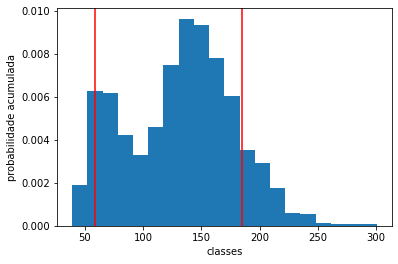

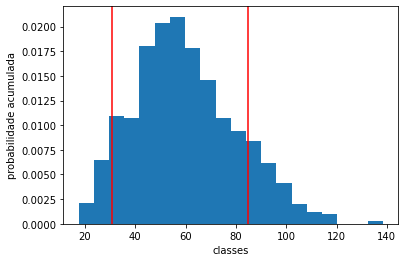

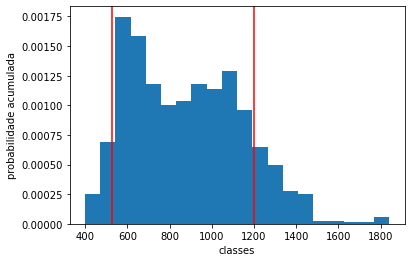

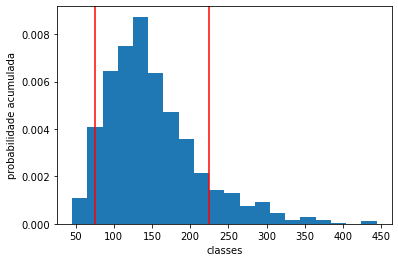

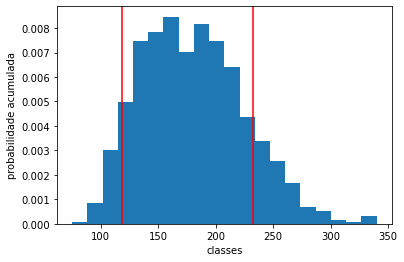

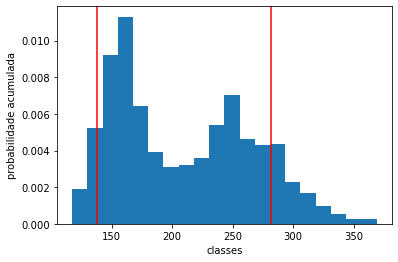

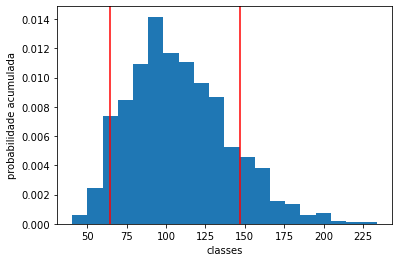

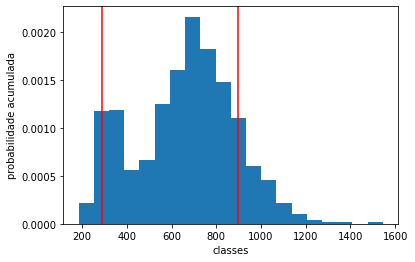

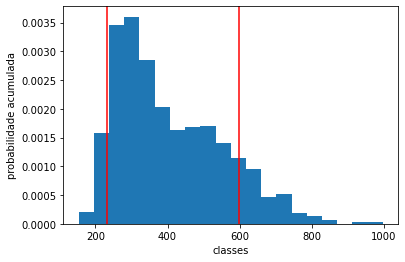

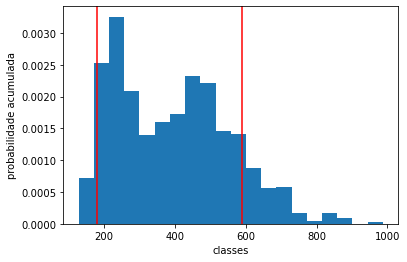

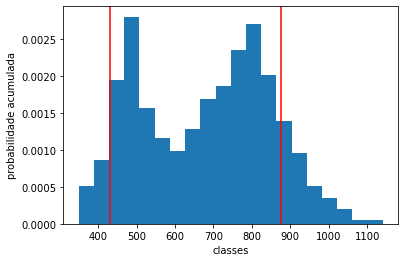

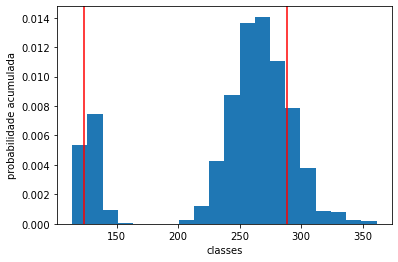

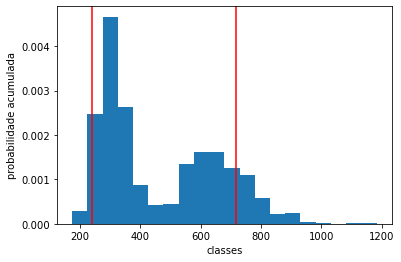

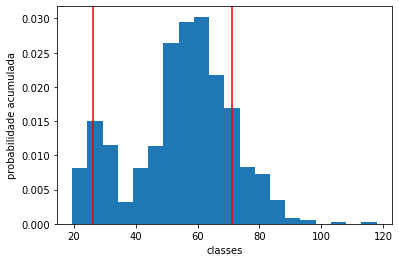

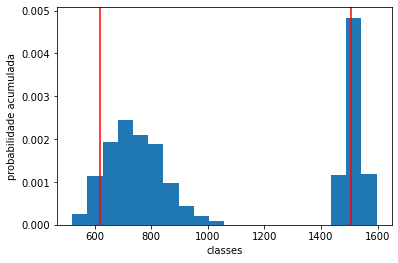

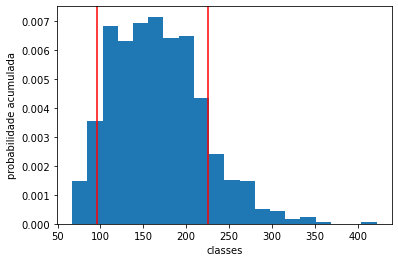

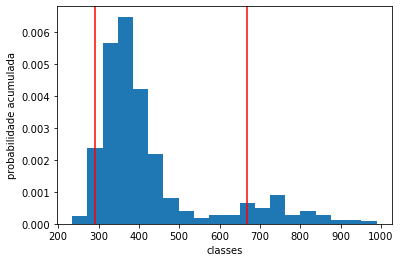

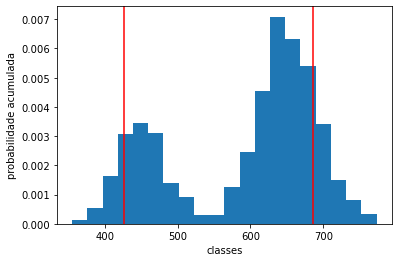

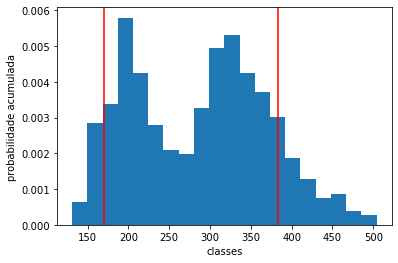

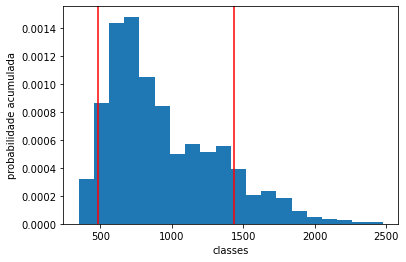

In [30]:
for i in range(n_projetos):
    plt.figure(i)
    VisualizarVA(projetos['volume condicional'][i])

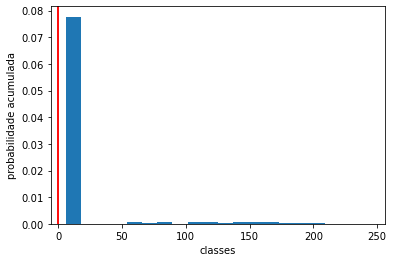

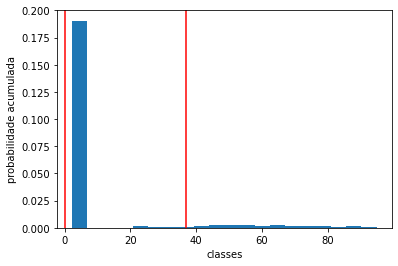

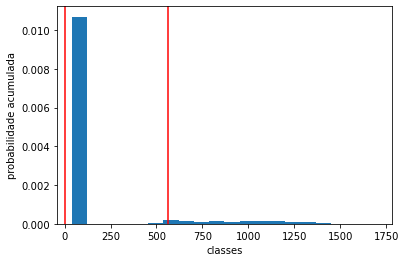

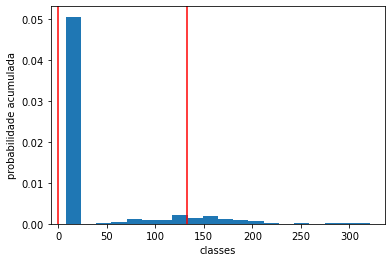

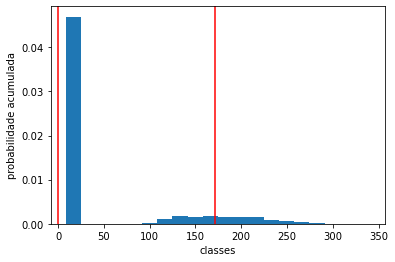

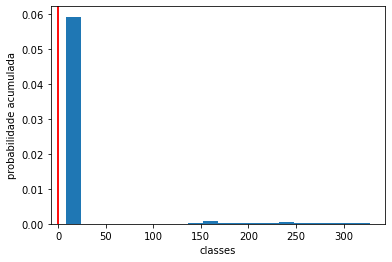

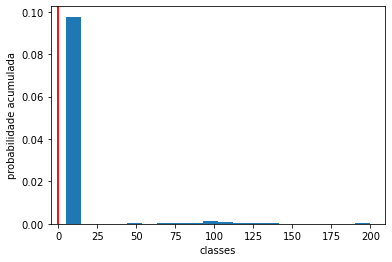

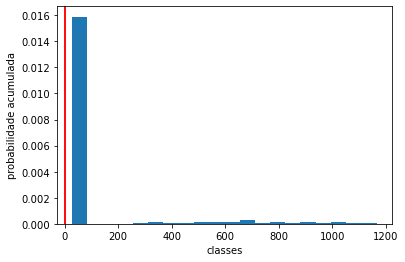

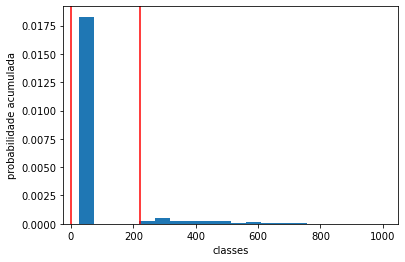

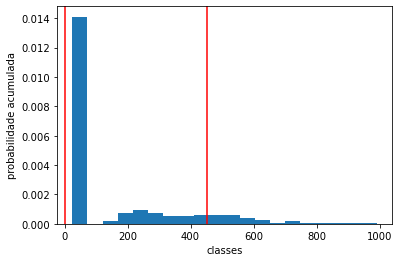

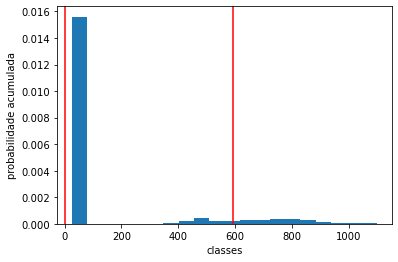

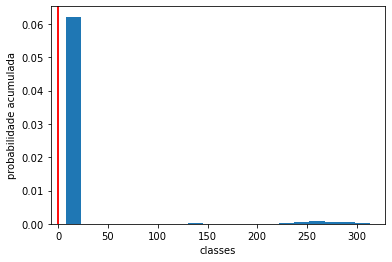

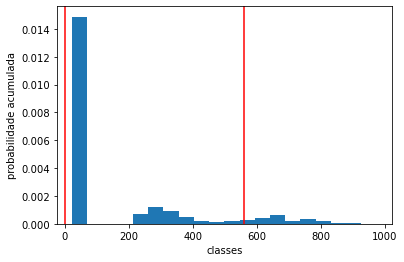

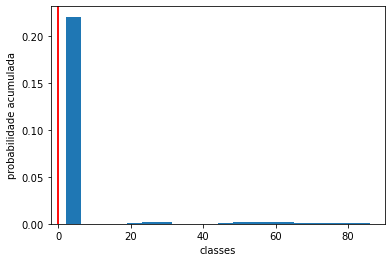

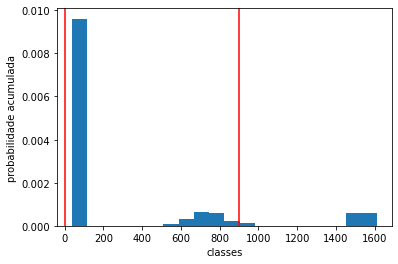

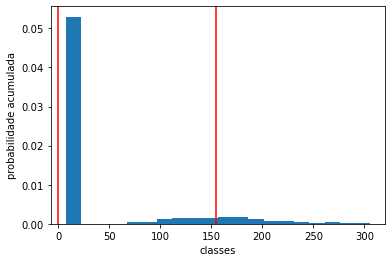

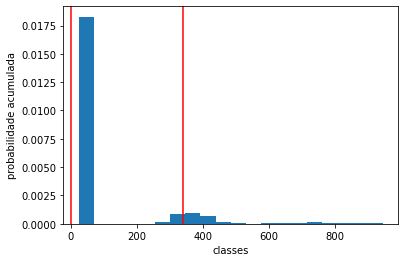

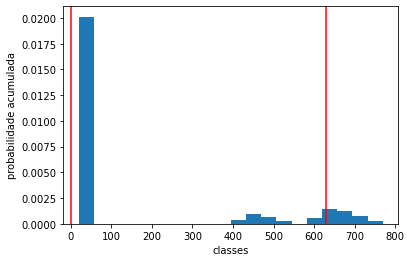

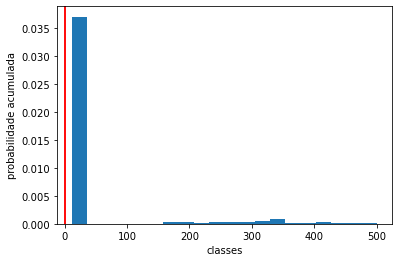

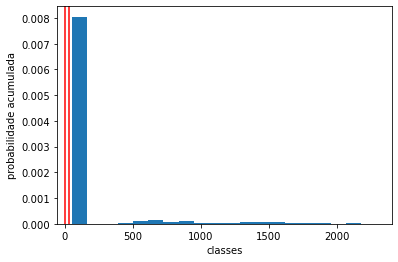

In [31]:
for i in range(n_projetos):
    plt.figure(i)
    VisualizarVA(projetos['volume incondicional'][i])

## Calibração econômica: $f(volume) \rightarrow VPL$

In [32]:
def AvalEcon(vol, fixo, unit):
    vpl = - fixo + (vol * unit)
    return vpl

def CalibEcon(dist, fixo, unit):
    vpl_dist = []
    for v in dist:
        vpl = AvalEcon(v, fixo, unit)
        vpl_dist.append(vpl)
    return vpl_dist

In [33]:
projetos['VPL condicional'] = []
projetos['VPL incondicional'] = []
projetos['VPL condicional médio'] = []
projetos['VPL incondicional médio'] = []
for i in range(n_projetos):
    vpl_dist_cond = CalibEcon(projetos['volume condicional'][i], fixo=1000, unit=5)
    vpl_dist_incond = CalibEcon(projetos['volume incondicional'][i], fixo=1000, unit=5)
    projetos['VPL condicional'].append(copy.copy(vpl_dist_cond))
    projetos['VPL incondicional'].append(copy.copy(vpl_dist_incond))
    projetos['VPL condicional médio'].append(np.mean(vpl_dist_cond))
    projetos['VPL incondicional médio'].append(np.mean(vpl_dist_incond))

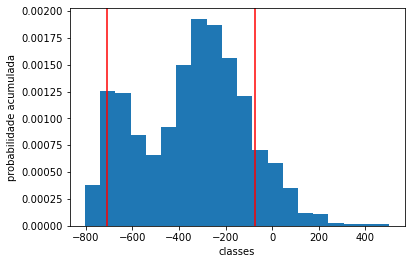

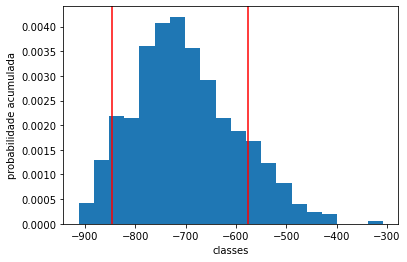

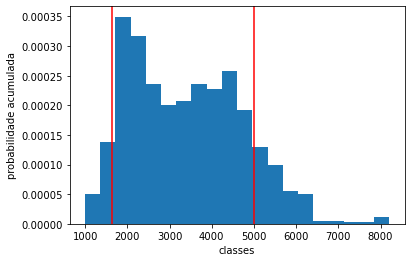

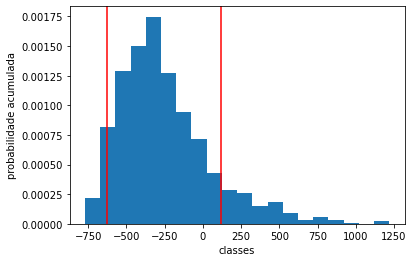

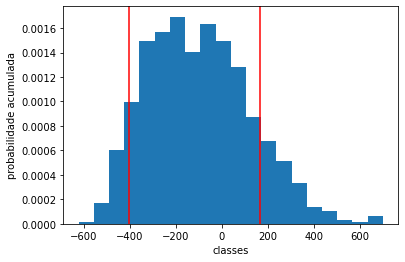

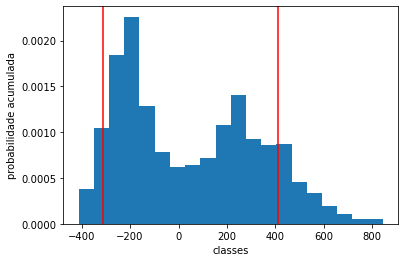

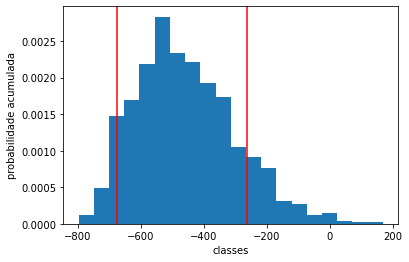

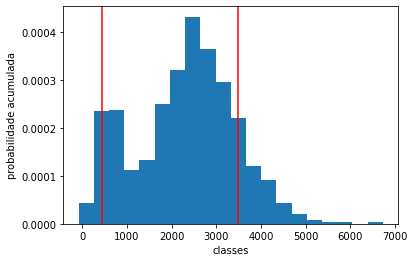

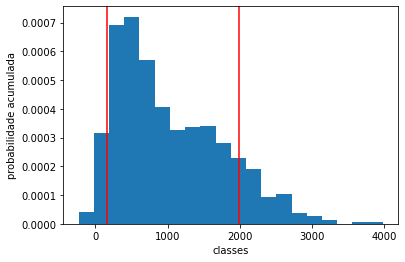

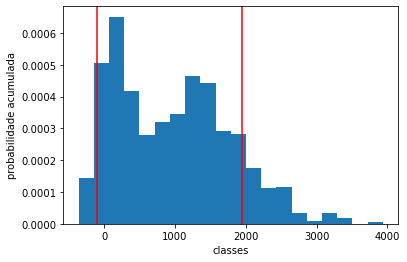

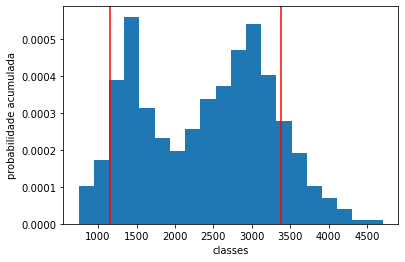

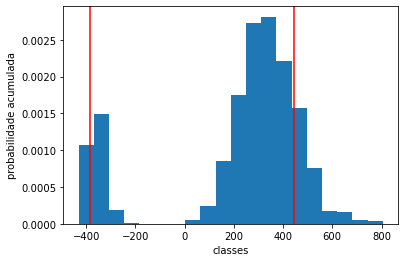

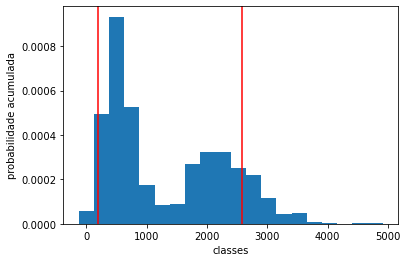

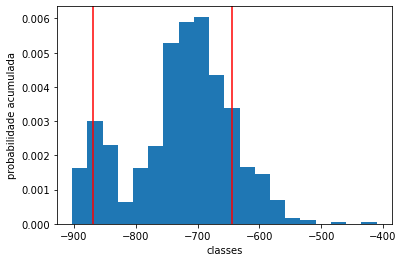

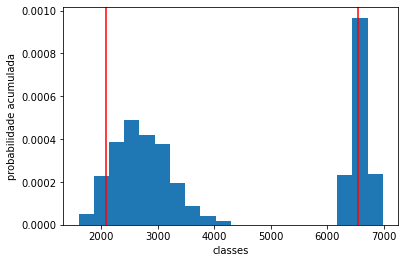

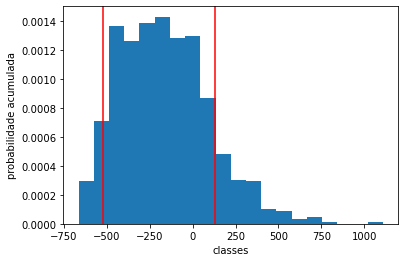

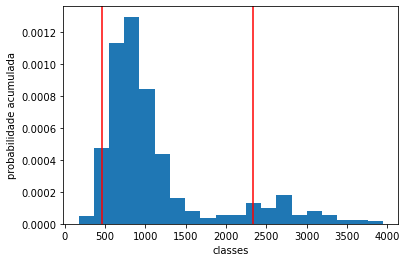

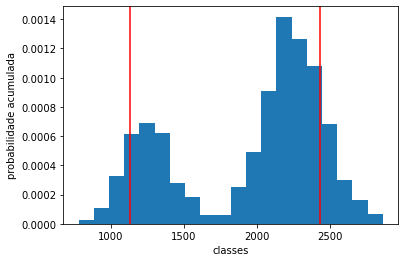

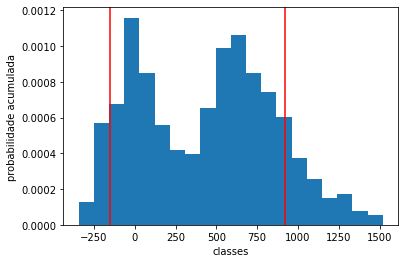

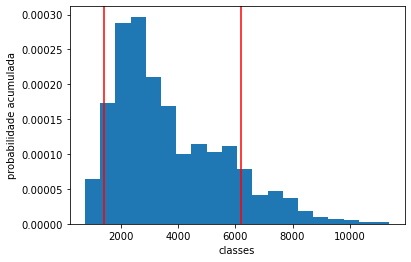

In [34]:
for i in range(n_projetos):
    plt.figure(i)
    VisualizarVA(projetos['VPL condicional'][i])

In [35]:
proj_df = pd.DataFrame(projetos)

In [36]:
proj_df.head()

,Coordenada x,Coordenada y,Bacia,Nome,Maturidade bacia,Qualidade do dado,Play,Soterramento,pcgna,area,...,volume gna,volume cond,volume condicional,média condicional,volume incondicional,média incondicional,VPL condicional,VPL incondicional,VPL condicional médio,VPL incondicional médio
0,44.143174,19.176742,Bacia2,Projeto 1,Estrutura pronta,Qualidade alta,Play 4,1300.219960,0.728105,<scipy.stats._distn_infrastructure.rv_frozen o...,...,"[34.62143899369812, 59.692860244258874, 45.884...","[5.710116857178474, 9.300082299692708, 7.99685...","[126.97842042771822, 238.53956588542724, 97.78...",125.377606,"[0, 238.53956588542724, 0, 0, 0, 0, 0, 0, 0, 0...",9.326996,"[-365.1078978614089, 192.69782942713618, -511....","[-1000, 192.69782942713618, -1000, -1000, -100...",-373.111972,-953.365020
1,46.111843,7.037111,Bacia2,Projeto 2,Estrutura pronta,Qualidade alta,Play 2,2948.445884,0.854816,<scipy.stats._distn_infrastructure.rv_frozen o...,...,"[27.123832611291768, 20.984937196377512, 18.39...","[2.8410488544477706, 2.3137448665753344, 1.960...","[27.024179604807575, 39.056560292914796, 46.01...",56.928716,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 80.690...",6.535284,"[-864.8791019759622, -804.717198535426, -769.9...","[-1000, -1000, -1000, -1000, -1000, -1000, -10...",-715.356420,-967.323581
2,43.959508,20.146113,Bacia2,Projeto 3,Estrutura pronta,Qualidade alta,Play 7,2787.541120,0.533949,<scipy.stats._distn_infrastructure.rv_frozen o...,...,"[596.2647118179476, 712.3179872374695, 404.620...","[79.38065300409033, 94.35824966875967, 51.1444...","[1067.7660440284576, 675.6453648220379, 806.67...",846.116151,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 835.39453290...",102.182115,"[4338.830220142288, 2378.226824110189, 3033.38...","[-1000, -1000, -1000, -1000, -1000, -1000, -10...",3230.580756,-489.089423
3,92.078156,90.396075,Bacia9,Projeto 4,Nova fronteira,Qualidade alta,Play 6,1411.462092,0.633614,<scipy.stats._distn_infrastructure.rv_frozen o...,...,"[109.90198733282111, 122.2876264182817, 44.784...","[16.65315405411809, 18.587648197241304, 7.1150...","[126.5551413869392, 157.16014625938493, 140.87...",140.944684,"[126.5551413869392, 0, 0, 0, 51.89976004848413...",28.163269,"[-367.224293065304, -214.1992687030754, -295.6...","[-367.224293065304, -1000, -1000, -1000, -740....",-295.276579,-859.183656
4,20.307964,44.496946,Bacia4,Projeto 5,Estrutura em construção,Qualidade baixa,Play 6,1626.361896,0.618446,<scipy.stats._distn_infrastructure.rv_frozen o...,...,"[142.7928882362581, 98.05223883299871, 122.768...","[18.463006551119083, 17.63751175593723, 22.408...","[227.89019436204924, 180.90412359915769, 195.9...",173.880883,"[0, 0, 0, 186.96529959067703, 0, 0, 161.255894...",37.779648,"[139.4509718102463, -95.47938200421163, -20.04...","[-1000, -1000, -1000, -65.17350204661489, -100...",-130.595586,-811.101762


## Calculando custo por poço perfurado

In [37]:
def CustoPoco(soterramento, maturidade):
    unit_loc = {'Nova fronteira': 2,
            'Estrutura em construção': 1.5,
            'Estrutura pronta': 1}
    unit = 20000
    custo = soterramento*unit*unit_loc[maturidade]
    return custo / 10**6
    

In [38]:
projetos['Custo do poço'] = []
for i in range(n_projetos):
    projetos['Custo do poço'].append(CustoPoco(projetos['Soterramento'][i], projetos['Maturidade bacia'][i]))

In [39]:
proj_df = pd.DataFrame(projetos)

In [40]:
proj_df.head()

,Coordenada x,Coordenada y,Bacia,Nome,Maturidade bacia,Qualidade do dado,Play,Soterramento,pcgna,area,...,volume cond,volume condicional,média condicional,volume incondicional,média incondicional,VPL condicional,VPL incondicional,VPL condicional médio,VPL incondicional médio,Custo do poço
0,44.143174,19.176742,Bacia2,Projeto 1,Estrutura pronta,Qualidade alta,Play 4,1300.219960,0.728105,<scipy.stats._distn_infrastructure.rv_frozen o...,...,"[5.710116857178474, 9.300082299692708, 7.99685...","[126.97842042771822, 238.53956588542724, 97.78...",125.377606,"[0, 238.53956588542724, 0, 0, 0, 0, 0, 0, 0, 0...",9.326996,"[-365.1078978614089, 192.69782942713618, -511....","[-1000, 192.69782942713618, -1000, -1000, -100...",-373.111972,-953.365020,26.004399
1,46.111843,7.037111,Bacia2,Projeto 2,Estrutura pronta,Qualidade alta,Play 2,2948.445884,0.854816,<scipy.stats._distn_infrastructure.rv_frozen o...,...,"[2.8410488544477706, 2.3137448665753344, 1.960...","[27.024179604807575, 39.056560292914796, 46.01...",56.928716,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 80.690...",6.535284,"[-864.8791019759622, -804.717198535426, -769.9...","[-1000, -1000, -1000, -1000, -1000, -1000, -10...",-715.356420,-967.323581,58.968918
2,43.959508,20.146113,Bacia2,Projeto 3,Estrutura pronta,Qualidade alta,Play 7,2787.541120,0.533949,<scipy.stats._distn_infrastructure.rv_frozen o...,...,"[79.38065300409033, 94.35824966875967, 51.1444...","[1067.7660440284576, 675.6453648220379, 806.67...",846.116151,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 835.39453290...",102.182115,"[4338.830220142288, 2378.226824110189, 3033.38...","[-1000, -1000, -1000, -1000, -1000, -1000, -10...",3230.580756,-489.089423,55.750822
3,92.078156,90.396075,Bacia9,Projeto 4,Nova fronteira,Qualidade alta,Play 6,1411.462092,0.633614,<scipy.stats._distn_infrastructure.rv_frozen o...,...,"[16.65315405411809, 18.587648197241304, 7.1150...","[126.5551413869392, 157.16014625938493, 140.87...",140.944684,"[126.5551413869392, 0, 0, 0, 51.89976004848413...",28.163269,"[-367.224293065304, -214.1992687030754, -295.6...","[-367.224293065304, -1000, -1000, -1000, -740....",-295.276579,-859.183656,56.458484
4,20.307964,44.496946,Bacia4,Projeto 5,Estrutura em construção,Qualidade baixa,Play 6,1626.361896,0.618446,<scipy.stats._distn_infrastructure.rv_frozen o...,...,"[18.463006551119083, 17.63751175593723, 22.408...","[227.89019436204924, 180.90412359915769, 195.9...",173.880883,"[0, 0, 0, 186.96529959067703, 0, 0, 161.255894...",37.779648,"[139.4509718102463, -95.47938200421163, -20.04...","[-1000, -1000, -1000, -65.17350204661489, -100...",-130.595586,-811.101762,48.790857


## Calculando tempo de execução por poço perfurado

In [41]:
def TempoExecucao(soterramento, maturidade):
    unit_loc = {'Nova fronteira': 3,
            'Estrutura em construção': 2,
            'Estrutura pronta': 1}
    unit = (100 / 5000)
    tempo = soterramento*unit*unit_loc[maturidade]
    return tempo

In [42]:
projetos['Tempo de execução'] = []
for i in range(n_projetos):
    projetos['Tempo de execução'].append(TempoExecucao(projetos['Soterramento'][i], projetos['Maturidade bacia'][i]))

In [43]:
proj_df = pd.DataFrame(projetos)

In [44]:
proj_df.head()

,Coordenada x,Coordenada y,Bacia,Nome,Maturidade bacia,Qualidade do dado,Play,Soterramento,pcgna,area,...,volume condicional,média condicional,volume incondicional,média incondicional,VPL condicional,VPL incondicional,VPL condicional médio,VPL incondicional médio,Custo do poço,Tempo de execução
0,44.143174,19.176742,Bacia2,Projeto 1,Estrutura pronta,Qualidade alta,Play 4,1300.219960,0.728105,<scipy.stats._distn_infrastructure.rv_frozen o...,...,"[126.97842042771822, 238.53956588542724, 97.78...",125.377606,"[0, 238.53956588542724, 0, 0, 0, 0, 0, 0, 0, 0...",9.326996,"[-365.1078978614089, 192.69782942713618, -511....","[-1000, 192.69782942713618, -1000, -1000, -100...",-373.111972,-953.365020,26.004399,26.004399
1,46.111843,7.037111,Bacia2,Projeto 2,Estrutura pronta,Qualidade alta,Play 2,2948.445884,0.854816,<scipy.stats._distn_infrastructure.rv_frozen o...,...,"[27.024179604807575, 39.056560292914796, 46.01...",56.928716,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 80.690...",6.535284,"[-864.8791019759622, -804.717198535426, -769.9...","[-1000, -1000, -1000, -1000, -1000, -1000, -10...",-715.356420,-967.323581,58.968918,58.968918
2,43.959508,20.146113,Bacia2,Projeto 3,Estrutura pronta,Qualidade alta,Play 7,2787.541120,0.533949,<scipy.stats._distn_infrastructure.rv_frozen o...,...,"[1067.7660440284576, 675.6453648220379, 806.67...",846.116151,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 835.39453290...",102.182115,"[4338.830220142288, 2378.226824110189, 3033.38...","[-1000, -1000, -1000, -1000, -1000, -1000, -10...",3230.580756,-489.089423,55.750822,55.750822
3,92.078156,90.396075,Bacia9,Projeto 4,Nova fronteira,Qualidade alta,Play 6,1411.462092,0.633614,<scipy.stats._distn_infrastructure.rv_frozen o...,...,"[126.5551413869392, 157.16014625938493, 140.87...",140.944684,"[126.5551413869392, 0, 0, 0, 51.89976004848413...",28.163269,"[-367.224293065304, -214.1992687030754, -295.6...","[-367.224293065304, -1000, -1000, -1000, -740....",-295.276579,-859.183656,56.458484,84.687726
4,20.307964,44.496946,Bacia4,Projeto 5,Estrutura em construção,Qualidade baixa,Play 6,1626.361896,0.618446,<scipy.stats._distn_infrastructure.rv_frozen o...,...,"[227.89019436204924, 180.90412359915769, 195.9...",173.880883,"[0, 0, 0, 186.96529959067703, 0, 0, 161.255894...",37.779648,"[139.4509718102463, -95.47938200421163, -20.04...","[-1000, -1000, -1000, -65.17350204661489, -100...",-130.595586,-811.101762,48.790857,65.054476


## Atribuindo contratos aos projetos

## Visualizando métricas dos projetos para controle de qualidade dos dados